In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')

In [3]:

from data_processing import load_csv
df = load_csv('../data/processed/cleaned_data.csv')
#df = pd.read_csv('../data/raw/data.csv')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [37]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,fraud_severity,amount_bracket
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0.0,"(0.0, 10000.0]"
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,20.0,20,2018-11-15 02:19:08+00:00,2,0,0.0,"(0.0, 10000.0]"
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,0.0,"(0.0, 10000.0]"
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0,0.0,"(10000.0, 100000.0]"
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,644.0,644,2018-11-15 03:34:21+00:00,2,0,0.0,"(0.0, 10000.0]"


In [38]:
# Create fraud severity tiers
df['fraud_severity'] = np.where(
    df['FraudResult'] == 1,
    np.log10(df['Amount']),  # Log-scale to handle extreme values
    0
)

# fraud based on amount

72 % of frauds are more than $1M


In [39]:
# Check fraud detection rate by amount brackets
bins = [0, 10000, 100000, 1000000, float('inf')]
df['amount_bracket'] = pd.cut(df['Amount'], bins)
fraud_rates = df.groupby('amount_bracket', observed=True)['FraudResult'].mean()
print(fraud_rates)

amount_bracket
(0.0, 10000.0]           0.000023
(10000.0, 100000.0]      0.001275
(100000.0, 1000000.0]    0.199336
(1000000.0, inf]         0.728395
Name: FraudResult, dtype: float64


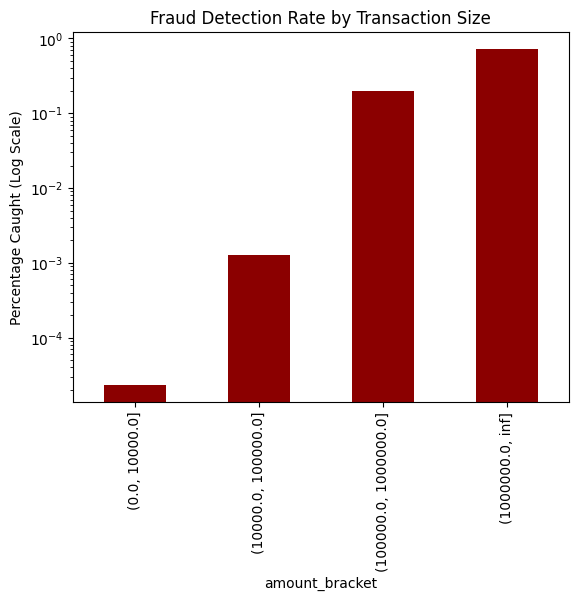

In [40]:
# Visualize detection gaps (log scale for readability)
import matplotlib.pyplot as plt
fraud_rates.plot(kind='bar', logy=True, color='darkred')
plt.title('Fraud Detection Rate by Transaction Size')
plt.ylabel('Percentage Caught (Log Scale)')
plt.show()

In [41]:
df.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'fraud_severity', 'amount_bracket'],
      dtype='object')

In [42]:
# Create a fraud severity score (log-scale for normalization)
df['fraud_severity'] = np.where(
    df['FraudResult'] == 1,
    np.log10(df['Amount'] + 1),  # +1 avoids log(0)
    0  # Non-fraud transactions get 0
)

# feature engineering
create new file for training the data

In [43]:
# This will create 'output.csv' if it doesn't exist and write a header row
with open('../data/processed/output.csv', 'w') as f:
    f.write('CustomerId\n')

In [44]:
#import output.csv
output_df = pd.read_csv('../data/processed/output.csv')

In [45]:
#SUM amounts of a customerid and store in output_df and costumerid
output_df['CustomerId'] = df['CustomerId'].unique()
output_df['total_amount'] = 0  # Initialize total_amount column
# Calculate total amount for each customer and store in output_df
output_df['total_amount'] = df.groupby('CustomerId')['Amount'].sum().reset_index(drop=True)

In [46]:
output_df['total_amount'].head()
output_df.shape

(3742, 2)

In [47]:
output_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742 entries, 0 to 3741
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerId    3742 non-null   object 
 1   total_amount  3742 non-null   float64
dtypes: float64(1), object(1)
memory usage: 58.6+ KB


In [48]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742 entries, 0 to 3741
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerId    3742 non-null   object 
 1   total_amount  3742 non-null   float64
dtypes: float64(1), object(1)
memory usage: 58.6+ KB


In [49]:
# Count number of transactions per CustomerId in df
customer_transactions = df['CustomerId'].value_counts().reset_index()
customer_transactions.columns = ['CustomerId', 'customer_transactions']

# Merge customer_transactions into output_df based on CustomerId
output_df = output_df.merge(customer_transactions, left_on='CustomerId', right_on='CustomerId', how='left')



In [50]:
# number of transactions per customer where fraud was detected
fraud_transactions = df[df['FraudResult'] == 1]['CustomerId'].value_counts().reset_index()
fraud_transactions.columns = ['CustomerId', 'fraud_transactions']
# Merge fraud_transactions into output_df based on CustomerId
output_df = output_df.merge(fraud_transactions, left_on='CustomerId', right_on='CustomerId', how='left')
# drop the 'CustomerId' column from the left DataFrame


In [51]:
output_df.head()

,CustomerId,total_amount,customer_transactions,fraud_transactions
0,CustomerId_4406,10000.0,119,NaN
1,CustomerId_4683,10000.0,2,NaN
2,CustomerId_988,30400.0,38,NaN
3,CustomerId_1432,4775.0,1,NaN
4,CustomerId_2858,32000.0,29,NaN


In [52]:
# print customer where fraud was detected in output_df
fraud_customers = output_df[output_df['fraud_transactions'] > 0]
print(fraud_customers[['CustomerId', 'fraud_transactions']])
fraud_customers.shape
#sum of fraud transactions
fraud_sum = fraud_customers['fraud_transactions'].sum()
print(f"Total fraud transactions: {fraud_sum}")

# Sum of total amount for fraud customers
total_fraud_amount = fraud_customers['total_amount'].sum()
print(f"Total amount for fraud customers: {total_fraud_amount}")



           CustomerId  fraud_transactions
10    CustomerId_2216                 2.0
43    CustomerId_4275                 3.0
47    CustomerId_7414                 2.0
69    CustomerId_2214                 1.0
111   CustomerId_5054                 7.0
375   CustomerId_4134                 1.0
508   CustomerId_3075                 7.0
513   CustomerId_4453                12.0
555   CustomerId_2353                 5.0
574   CustomerId_4391                 2.0
906   CustomerId_1858                 2.0
916   CustomerId_2528                 1.0
1077  CustomerId_5105                 1.0
1086  CustomerId_4878                22.0
1131   CustomerId_856                 4.0
1195   CustomerId_698                 1.0
1294  CustomerId_1122                 1.0
1362  CustomerId_2266                 7.0
1529  CustomerId_2445                 2.0
1736  CustomerId_2143                 1.0
1818   CustomerId_806                 1.0
1841  CustomerId_1653                 1.0
1866  CustomerId_3467             

In [53]:

#sum of amount where fraud was detected for each customer
fraud_amount_sum = fraud_customers.groupby('CustomerId')['total_amount'].sum().reset_index()
fraud_amount_sum.columns = ['CustomerId', 'total_fraud_amount']
# Merge fraud_amount_sum into output_df based on CustomerId
output_df = output_df.merge(fraud_amount_sum, left_on='CustomerId', right_on='CustomerId', how='left')


In [54]:
# Fraud ratio: % of transactions flagged as fraud
output_df['fraud_ratio'] = output_df['fraud_transactions'] / output_df['customer_transactions']

# Fraud amount ratio: % of total money involved in fraud
# (Requires total_fraud_amount column)
output_df['fraud_amount_ratio'] = output_df['total_fraud_amount'] / output_df['total_amount']

In [55]:
# priny the high fraud ratio customers
print(output_df[output_df['fraud_ratio'] > 0.1])

           CustomerId  total_amount  customer_transactions  \
43    CustomerId_4275       15675.0                      7   
47    CustomerId_7414      241710.0                      2   
375   CustomerId_4134      233990.0                      1   
508   CustomerId_3075       14050.0                     46   
513   CustomerId_4453      501000.0                     54   
574   CustomerId_4391       42000.0                     19   
1077  CustomerId_5105        1000.0                      8   
1086  CustomerId_4878        8200.0                    205   
1131   CustomerId_856      151200.0                      5   
1294  CustomerId_1122      200732.5                      1   
1736  CustomerId_2143        5000.0                      1   
1841  CustomerId_1653        4590.0                      6   
1922  CustomerId_5123        9570.0                      1   
1963  CustomerId_4128       21200.0                      1   
1976  CustomerId_3768      120400.0                     18   
2195  Cu

In [56]:
# Fraud-frequency interaction
output_df['fraud_frequency_score'] = output_df['fraud_ratio'] * np.log1p(output_df['customer_transactions'])

# High-value fraud indicator
output_df['high_value_fraud'] = (output_df['fraud_amount_ratio'] > 0.5).astype(int)

In [57]:
output_df.head()


,CustomerId,total_amount,customer_transactions,fraud_transactions,total_fraud_amount,fraud_ratio,fraud_amount_ratio,fraud_frequency_score,high_value_fraud
0,CustomerId_4406,10000.0,119,NaN,NaN,NaN,NaN,NaN,0
1,CustomerId_4683,10000.0,2,NaN,NaN,NaN,NaN,NaN,0
2,CustomerId_988,30400.0,38,NaN,NaN,NaN,NaN,NaN,0
3,CustomerId_1432,4775.0,1,NaN,NaN,NaN,NaN,NaN,0
4,CustomerId_2858,32000.0,29,NaN,NaN,NaN,NaN,NaN,0


In [58]:
output_df.columns

Index(['CustomerId', 'total_amount', 'customer_transactions',
       'fraud_transactions', 'total_fraud_amount', 'fraud_ratio',
       'fraud_amount_ratio', 'fraud_frequency_score', 'high_value_fraud'],
      dtype='object')

In [59]:
#sort in total_fraud_amount highest and print
print(output_df.sort_values(by='total_amount', ascending=False).head())

           CustomerId  total_amount  customer_transactions  \
3478  CustomerId_4338   104900000.0                     12   
3678  CustomerId_1961    83480760.0                      1   
400   CustomerId_2463    60212748.0                      7   
2952  CustomerId_5116    50912840.0                     17   
3180  CustomerId_4056    29763180.0                      9   

      fraud_transactions  total_fraud_amount  fraud_ratio  fraud_amount_ratio  \
3478                 NaN                 NaN          NaN                 NaN   
3678                 NaN                 NaN          NaN                 NaN   
400                  NaN                 NaN          NaN                 NaN   
2952                 NaN                 NaN          NaN                 NaN   
3180                 NaN                 NaN          NaN                 NaN   

      fraud_frequency_score  high_value_fraud  
3478                    NaN                 0  
3678                    NaN                 

In [60]:
#get last transaction date in cleaned_data
ref_date = df['TransactionStartTime'].max()

In [61]:
# Compute last transaction date per customer
last_txn = df.groupby('CustomerId')['TransactionStartTime'].max().reset_index()
last_txn.columns = ['CustomerId', 'last_transaction_date']

# Merge into output_df
output_df = output_df.merge(last_txn, on='CustomerId', how='left')

In [62]:
# save output_df  and df to csv
output_df.to_csv('../data/processed/output.csv', index=False)
df.to_csv('../data/processed/cleaned_data.csv', index=False)



In [63]:
output_df.columns

Index(['CustomerId', 'total_amount', 'customer_transactions',
       'fraud_transactions', 'total_fraud_amount', 'fraud_ratio',
       'fraud_amount_ratio', 'fraud_frequency_score', 'high_value_fraud',
       'last_transaction_date'],
      dtype='object')